# Denoising of VSD signals of propagating waves in awake monkey visual cortex with Linear Models

The purpose of this notebook is to denoise raw VSD signals of neuronal populations' activity in the visual cortex of awake monkeys using the methods developed by Reynaud et al. in https://doi.org/10.1016/j.neuroimage.2010.08.041

This procedure is based on Linear-Model (LM) decomposition of the signal. It requires a prior knowledge of the different sources of noise (heartbeat for example) and the shape of the response to denoise. It is a challenge since the methods were already designed to denoise evoked response, whereas here we want also to denoise spontaneous response.

The goal is to develop the same procedure as Reynaud but generalised so that we could use it either on awakeness or anaesthesia, or either with evoked or spontaneous activity.

AJOUTER LE PLAN 

1 : intro on propagating waves in Bks-processed signal

2 : properties of raw signals 

3 : Linear Model design

4 : LM-denoised VSD signal

### Importation

In [153]:
%matplotlib widget
import matplotlib.pyplot as plt
import matplotlib.animation as anim
import matplotlib.colors as colors
import numpy as np
import scipy.ndimage as img
import scipy.signal as signal
import scipy.stats as stat
from sklearn.linear_model import LinearRegression

## 0 : Data loading

Data available are videos of spontaneous and evoked activity int he visual cortex, recorded with ultra fast camera (Fs=110Hz). Raw signals are provided and preprocessed ones (Bks method: zero-frame division, blank substraction and z-score of raw data).

In [154]:
raw_blank_path = r'C:\Users\mmill\Desktop\Data VSD\Awakeness\raw_blank_z210908.npy'
raw_evoked_path = r'C:\Users\mmill\Desktop\Data VSD\Awakeness\raw_pos4_z210908.npy'

bks_blank_path = r'C:\Users\mmill\Desktop\Data VSD\Awakeness\blank_ziggy_210908.npy'
bks_evoked_path = r'C:\Users\mmill\Desktop\Data VSD\Awakeness\gaussian_pos4_ziggy_210908.npy'

awak_pattern_path = r'C:\Users\mmill\Desktop\Data VSD\Awakeness\Awake.bmp'

In [155]:
Raw_blank = np.load(raw_blank_path)
Raw_evoked = np.load(raw_evoked_path)

Bks_blank = np.load(bks_blank_path)
Bks_evoked = np.load(bks_evoked_path)

Vasc_pattern = plt.imread(awak_pattern_path)

In [156]:
Bks_data = np.append(Bks_blank, Bks_evoked, axis=0)
Raw_data = np.append(Raw_blank, Raw_evoked, axis=0)

## 1 : What do we want to denoise? Visualisation of travelling waves on Bks-processed trials

### 1.0 : intro

Here is a little introduction about travelling waves, the phenomenon we want to analyse in depth. I used a dataset generated after the "Bks" denoising procedure, i.e. another type of denoising method very easy to conduct but also not very specific. It's based on the "zero-frame division", which is the normalisation of the fluorescence activity by dividing pixel values over the mean fluorescence value on the first frames (=zero-frames). Then, the data are substracted with the 'blanks', another recording of activity with the same dimension. Finally, data are z-scored. 

Reynaud et al. showed in their 2011 paper that this technique is easy but very noise-sensitive. So we'll just use this dataset in this section to understand better the type of signal we have, and then we'll try to denoise the raw data with Linear Models.

In [157]:
N_trials, Nt, Nx, Ny = Bks_evoked.shape
Bks_blank_masked = np.ma.masked_invalid(Bks_blank)
Bks_evoked_masked = np.ma.masked_invalid(Bks_evoked)
Bks_masked = np.ma.masked_invalid(Bks_data)

There is a 'dead pixel' in the Bks dataset, so we need to mask its values before plotting the histogram

In [158]:
histo_blank, edges = np.histogram(Bks_blank_masked.compressed(), bins=200, density=True)
histo_evoked, _ = np.histogram(Bks_evoked_masked.compressed(), bins=200, density=True)
histo_tot, _ = np.histogram(Bks_masked.compressed(), bins=200, density=True)

Fit=stat.norm.pdf(edges[:-1])

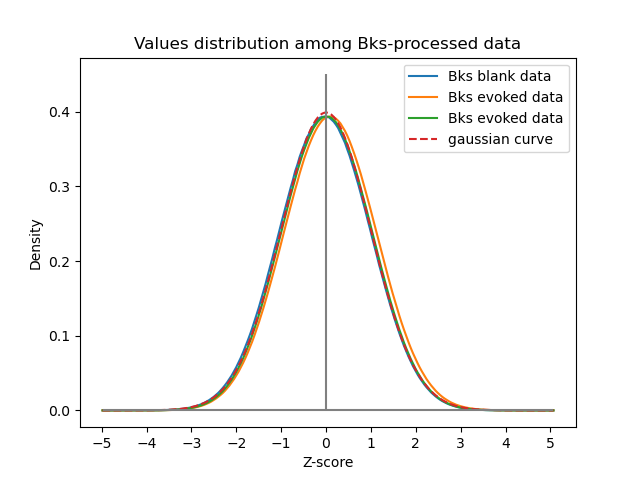

In [159]:
plt.figure()
plt.title('Values distribution among Bks-processed data')
plt.xlabel('Z-score')
plt.ylabel('Density')
plt.plot(edges[:-1],histo_blank,label='Bks blank data')
plt.plot(edges[:-1],histo_evoked,label='Bks evoked data')
plt.plot(edges[:-1],histo_tot,label='Bks evoked data')
plt.plot(edges[:-1],Fit,label='gaussian curve', linestyle='dashed')
plt.hlines(0, edges[0], edges[-2], 'gray')
plt.vlines(0,0,.45,'gray')
plt.xticks(range(-5,6))
plt.legend()
plt.show()

We can observe after a quick focus near the top of the curves that data are close to a normal distribution, especially the merged set, but also that the evoked set is a bit shifted to the positive values, contrary to the blank set.

To analyse a beautiful evoked wave, we will take the trial n°8 in the Bks-processed/evoked/awake dataset.

In [160]:
n_trial = 8
Sample = np.copy(Bks_evoked[n_trial])

FILM OF RAW DATA 

A SMOOTHING IS REQUIRED

### 1.1 : Smoothing the data to see the wave

#### Temporal filtering (Butterworth filter : lowpass under 20Hz)

In [161]:
butt_filt = signal.butter(N=4, Wn=[20], btype='lowpass', fs=110, output='sos')
Sample=signal.sosfiltfilt(butt_filt, Sample, axis=0)

#### Spatial smoothing (Gaussian filter)

In [162]:
mean = np.nanmean(Sample)
nan_mask = np.isnan(Sample)
Sample[nan_mask]=mean
Smooth  = np.zeros_like(Sample)
for i in range(Nt):
    Smooth[i]=img.gaussian_filter(Sample[i], sigma=5, mode='constant', cval=mean)
Sample=Smooth
Sample[nan_mask]=np.nan

#### Z-score of the data

In [163]:
mean = np.nanmean(Sample)
std = np.nanstd(Sample)
Sample=(Sample-mean)/std

### 1.2 : Visualisation of waves

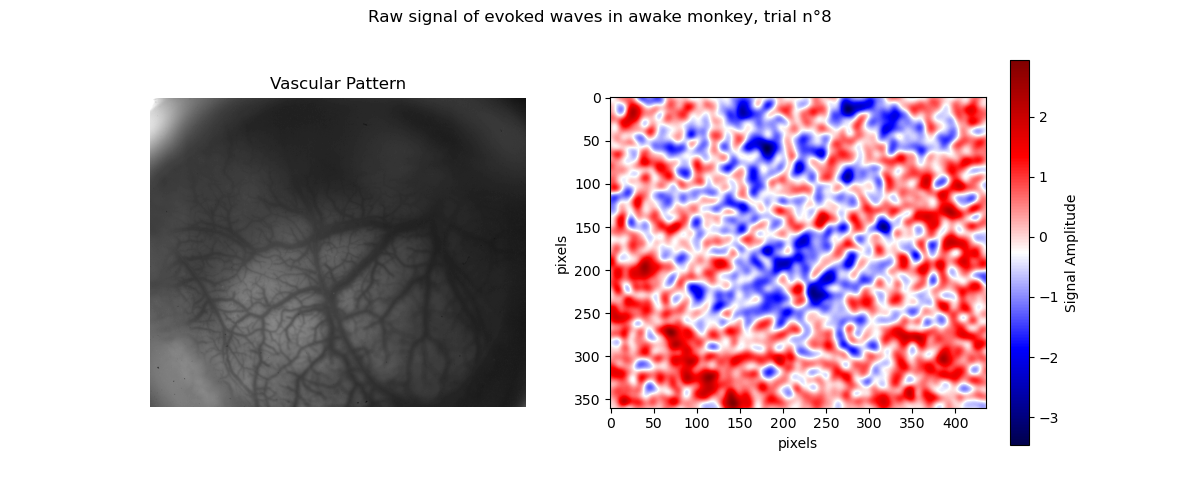

In [164]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,5), width_ratios=[0.80,1])
fig.suptitle('Raw signal of evoked waves in awake monkey, trial n°'+str(n_trial))

vasculature = ax1.imshow(Vasc_pattern, cmap='gray', aspect='equal')

vsd_signal = ax2.imshow(Sample[0], cmap='seismic', aspect='equal')

cbar = fig.colorbar(vsd_signal, ax=ax2, label='Signal Amplitude')

ax1.set_title('Vascular Pattern')
ax1.axis('off')

ax2.set_xlabel('pixels')
ax2.set_ylabel('pixels')

def update(frame):
    vsd_signal.set_array(Sample[frame])
    ax2.set_title('frame n°'+str(frame))
    return [vsd_signal]

ani = anim.FuncAnimation(fig,func=update,frames=range(Nt),interval=100,repeat=False)
plt.show()


We can observe a noisy traveling wave from frames 23 to 40. Let's put a mask to remove the border to see more clearly the wave. 

### 1.3 : Masking the border

As the recording aperture is circular, we can use a circular mask, defining the border (out of the circle) and the center (in the circle)

In [165]:
def circular_mask(shape, center, radius):
    Y, X = np.ogrid[:shape[0], :shape[1]]
    return ((X - center[0]) ** 2 + (Y - center[1]) ** 2) <= radius ** 2

In [166]:
image_mask = circular_mask(Sample.shape[1:], center=(220,190), radius=175)

N_center = np.sum(image_mask)
N_border = np.sum(~image_mask)

film_mask = np.array([image_mask for _ in range(Nt)])
                      
masked_sample = np.copy(Sample)
masked_sample[~film_mask]=np.nan

center_series = np.transpose(Sample[:,image_mask])

C:\Users\mmill\anaconda3\envs\myspyder-env\Lib\site-packages\matplotlib\animation.py:892: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you output the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


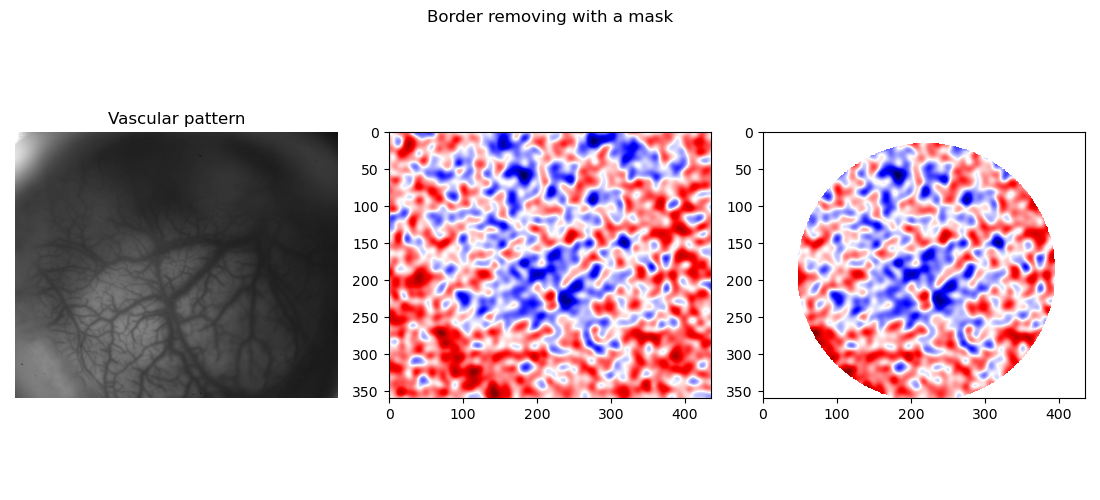

In [167]:
fig, axs = plt.subplots(1,3, tight_layout=True, figsize=(11,5))
fig.suptitle('Border removing with a mask')

axs[0].set_title("Vascular pattern")
axs[0].imshow(Vasc_pattern, cmap='gray', aspect='equal')
axs[0].axis('off')

unmasked = axs[1].imshow(Sample[0], cmap='seismic', aspect='equal')

masked = axs[2].imshow(masked_sample[0], cmap='seismic', aspect='equal')


def update(frame):
    unmasked.set_array(Sample[frame])
    masked.set_array(masked_sample[frame])
    axs[1].set_title('frame n°'+str(frame))
    axs[2].set_title('frame n°'+str(frame))
    return [unmasked, masked]

ani = anim.FuncAnimation(fig,func=update,frames=range(Nt),interval=100,repeat=False)
plt.show()

In [168]:
plt.close()

AJOUTER ANALYSE STATISTIQUE DES DATA AVEC OU SANS BORDS

### 1.4 : Time series of the Bks-processed signals

Plot time series of randomly-picked pixels within the center

#### Random picking

In [169]:
n_picks = 1000

Picked_indices = np.sort(np.random.choice(N_center, n_picks))

Series = center_series[Picked_indices, :]

#### Temporal and total (spatial and temporal) averages of the time series

In [170]:
µ_tot, std_tot = np.nanmean(Series),np.nanstd(Series)
µ, std =np.nanmean(Series, axis=0), np.nanstd(Series, axis=0)

#### Finding the pixels implied in the wave

In [171]:
Wave_indices = np.max(Series, axis=1)>µ_tot+2.5*std_tot

#### Time series plots

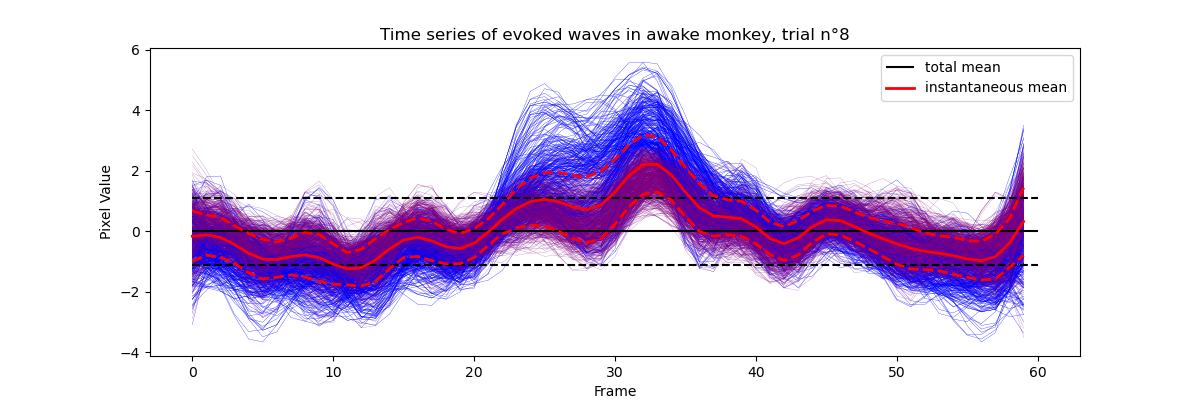

In [172]:
plt.figure(figsize=(12,4))
plt.title('Time series of evoked waves in awake monkey, trial n°'+str(n_trial))

plt.xlabel('Frame')
plt.ylabel('Pixel Value')

for i in range(n_picks):
    if Wave_indices[i]:
        plt.plot(Series[i,:], linewidth=.2, color='blue')
    else:
        plt.plot(Series[i,:], linewidth=.2, color='purple', alpha=.6)

plt.hlines(µ_tot, 0, Nt, 'k', linestyles='solid', label='total mean')
plt.hlines(µ_tot+std_tot, 0, Nt, 'k', linestyles='dashed')
plt.hlines(µ_tot-std_tot, 0, Nt, 'k', linestyles='dashed')

plt.plot(µ, 'red', linewidth=2, label='instantaneous mean')
plt.plot(µ+std, 'red', linewidth=2, linestyle='dashed')
plt.plot(µ-std, 'red', linewidth=2, linestyle='dashed')

plt.legend()
plt.show()

### 1.5 : Power spectra of the time series

In [173]:
fs=110 #Hz
freqs = np.fft.fftfreq(Nt, d=1/fs)
f = freqs[1:Nt//2-1]

ft = np.fft.fft(Series, axis=1)

ps = np.abs(ft)**2

mean_ps = np.mean(ps, axis=0)
ps_mean = np.abs(np.fft.fft(µ))**2

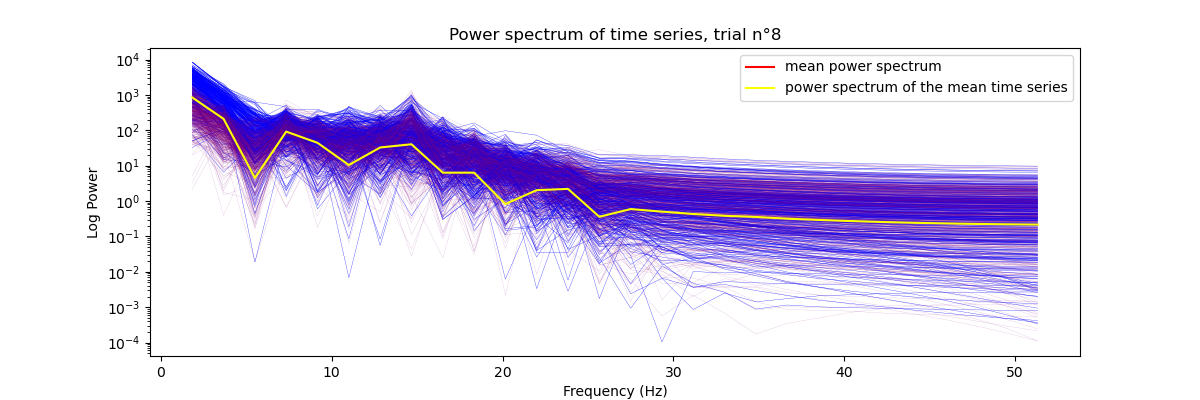

In [174]:
plt.figure(figsize=(12,4))
plt.title('Power spectrum of time series, trial n°'+str(n_trial))

plt.xlabel('Frequency (Hz)')
plt.ylabel('Log Power')
plt.yscale('log')


for i in range(n_picks):
    if Wave_indices[i]:
        plt.plot(f, ps[i,1:Nt//2-1], linewidth=.2, color='blue')
    else:
        plt.plot(f, ps[i,1:Nt//2-1], linewidth=.1, color='purple', alpha=.6)
        
plt.plot(f, mean_ps[1:Nt//2-1],color='red', label='mean power spectrum')
plt.plot(f, ps_mean[1:Nt//2-1],color='yellow', label='power spectrum of the mean time series')

plt.legend()
plt.show()

## 2 : Raw signal analysis

After this quick glaze upon processed data, we have to start from scratch with raw signals.

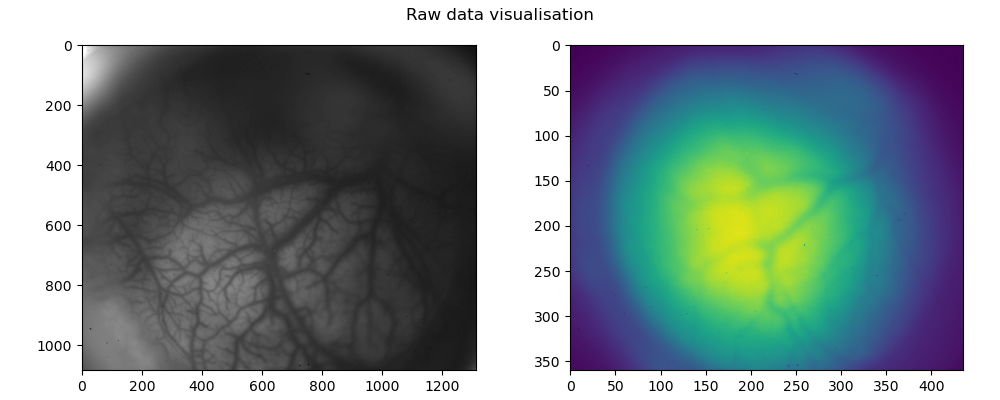

In [175]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4))
fig.suptitle('Raw data visualisation')
ax1.imshow(Vasc_pattern, cmap='gray')
ax2.imshow(Raw_blank[0,0])
plt.tight_layout()
plt.show()

So as you can see, raw data presents a clear visible vascular pattern, which is eliminated during the Blank-substraction step in Bks-proccessed data.

In [176]:
histo_raw_blank, edges = np.histogram(Raw_blank, bins=200, density=True)
histo_raw_evoked, _ = np.histogram(Raw_evoked, bins=200, density=True)
histo_raw_tot, _ = np.histogram(Raw_data, bins=200, density=True)

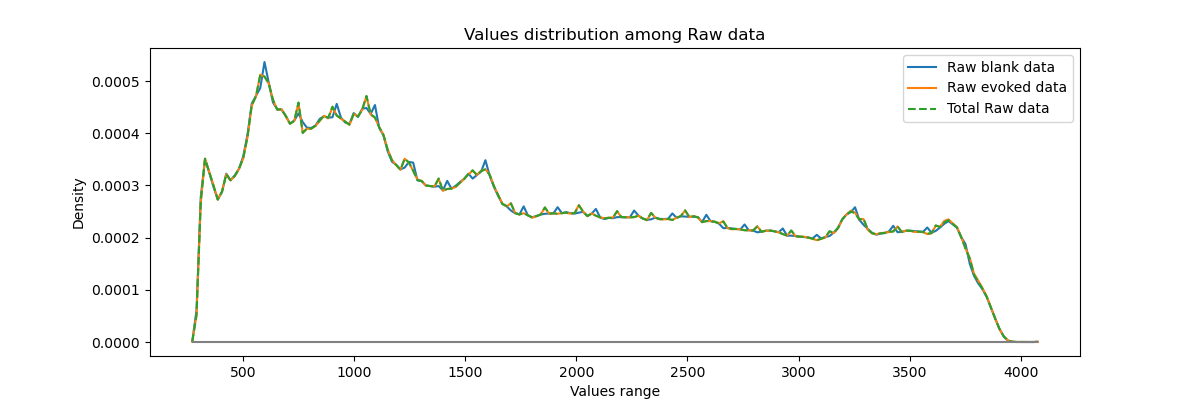

In [177]:
plt.figure(figsize=(12,4))
plt.title('Values distribution among Raw data')
plt.xlabel('Values range')
plt.ylabel('Density')
plt.plot(edges[:-1],histo_raw_blank,label='Raw blank data')
plt.plot(edges[:-1],histo_raw_evoked,label='Raw evoked data')
plt.plot(edges[:-1],histo_raw_tot,label='Total Raw data', linestyle='dashed')
plt.hlines(0, edges[0], edges[-2], 'gray')
plt.legend()
plt.show()

#### Bks process from Raw data

Zero-frame division

In [178]:
Raw_evoked_divided = Raw_evoked/np.mean(Raw_evoked[:,:15])
Raw_blank_divided = Raw_blank/np.mean(Raw_evoked[:,:15])

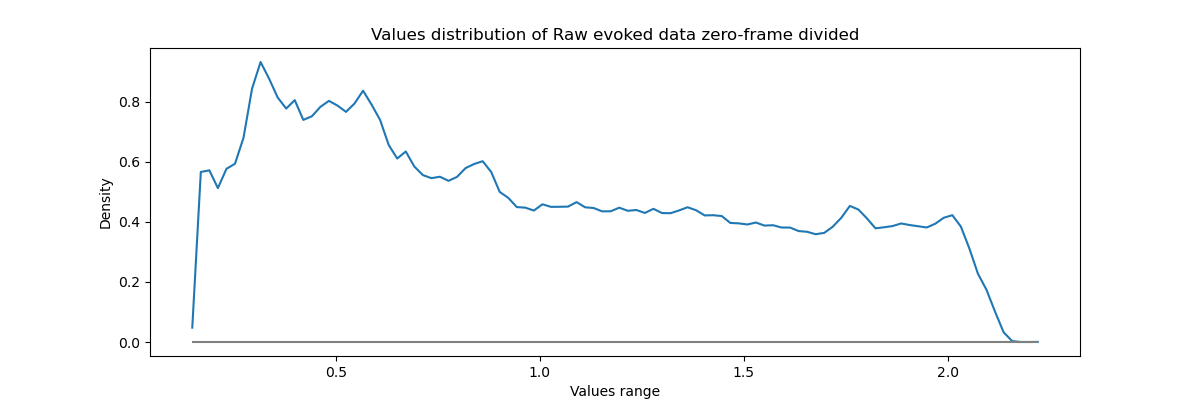

In [179]:
histo_raw_divided, edges_ = np.histogram(Raw_evoked_divided, bins=100, density=True)

plt.figure(figsize=(12,4))
plt.title('Values distribution of Raw evoked data zero-frame divided')
plt.xlabel('Values range')
plt.ylabel('Density')
plt.plot(edges_[:-1],histo_raw_divided)
plt.hlines(0, edges_[0], edges_[-2], 'gray')
plt.show()

Deblankation

In [180]:
Deblanked = Raw_evoked[:-1]-Raw_blank
Deblanked_divided = Raw_evoked_divided[:-1]-Raw_blank_divided

Z-scoring

In [181]:
Deblanked_zcored = (Deblanked-np.mean(Deblanked))/np.std(Deblanked)
Deblanked_divided_zcored = (Deblanked_divided-np.mean(Deblanked_divided))/np.std(Deblanked_divided)

In [182]:
histo_raw_deblanked, edges_ = np.histogram(Deblanked_zcored, bins=100, density=True)
histo_raw_deblanked_divided, edges_ = np.histogram(Deblanked_divided_zcored, bins=100, density=True)

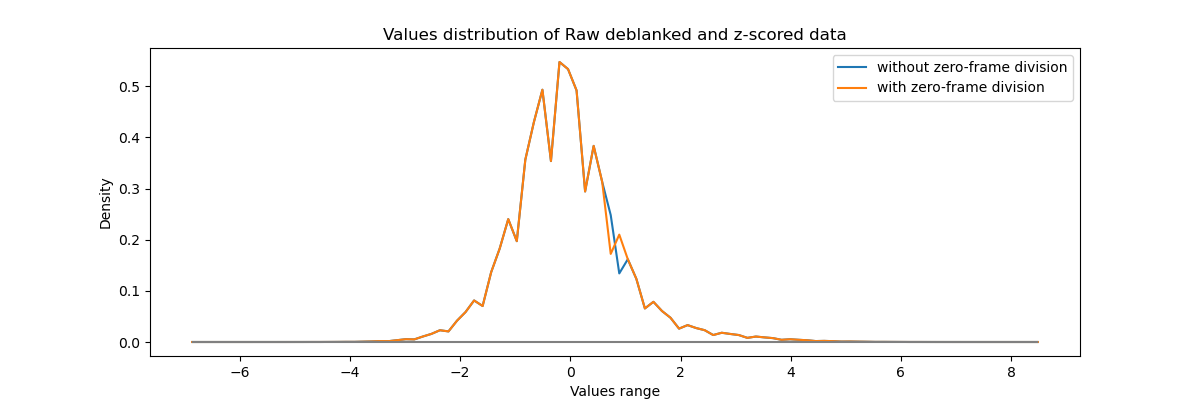

In [183]:
plt.figure(figsize=(12,4))
plt.title('Values distribution of Raw deblanked and z-scored data')
plt.xlabel('Values range')
plt.ylabel('Density')
plt.plot(edges_[:-1],histo_raw_deblanked, label='without zero-frame division')
plt.plot(edges_[:-1],histo_raw_deblanked_divided, label='with zero-frame division')
plt.hlines(0, edges_[0], edges_[-2], 'gray')
plt.legend()
plt.show()

Pratiquement pas de différences observées en terme de distribution de valeurs avec ou sans division. En revanche la distribution obtenue, bien que plutôt gausienne, n'est pas aussi lisse que celle du jeu de données Bks...

### Etude du débruitage au niveau d'un pixel unique impliqué dans une onde de propagation

Coordonnées du pixel 

In [184]:
x,y = 180, 210

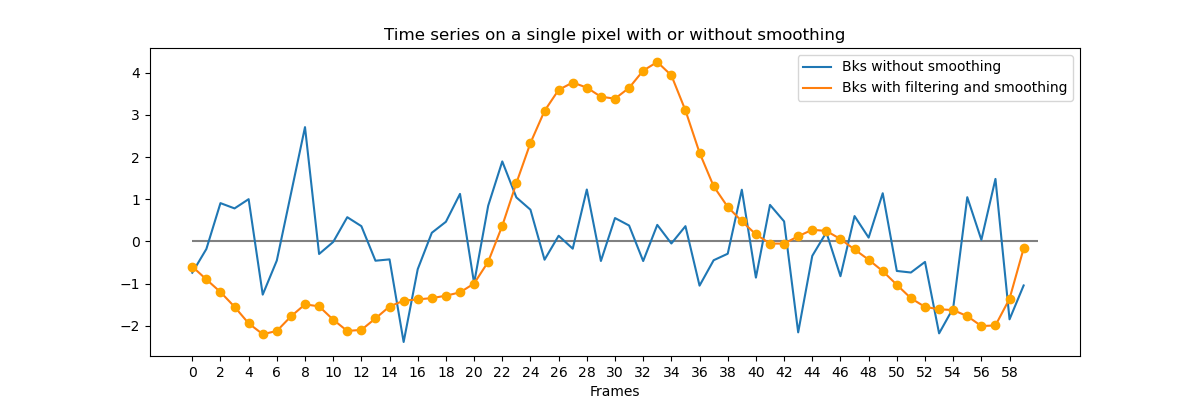

In [185]:
plt.figure(figsize=(12,4))
plt.title('Time series on a single pixel with or without smoothing')
plt.hlines(0,0,60, 'gray')
plt.xlabel('Frames')
plt.plot(Bks_evoked[8,:,x,y], label='Bks without smoothing')
plt.plot(Sample[:,x,y], label='Bks with filtering and smoothing')
plt.plot(Sample[:,x,y], 'o', color='orange')
plt.xticks(range(0,60,2))
plt.legend()
plt.show()

What does the Bks method changed on this pixel ?

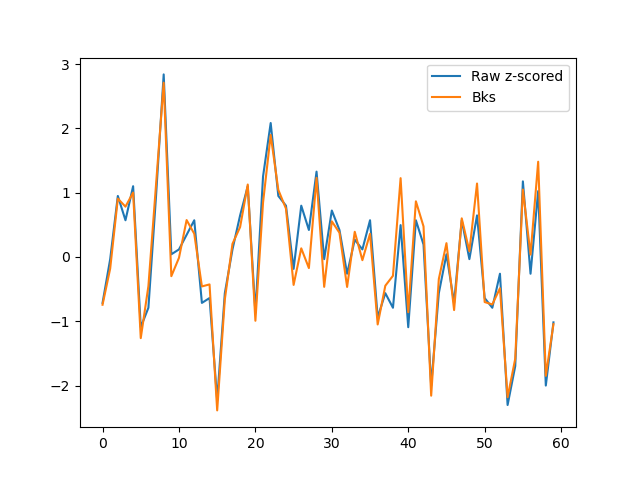

In [186]:
plt.figure()
plt.plot((Raw_evoked[8,:,x,y]-np.mean(Raw_evoked[8,:,x,y]))/np.std(Raw_evoked[8,:,x,y]), label='Raw z-scored')
plt.plot(Bks_evoked[8,:,x,y], label='Bks')
plt.legend()
plt.show()

In [187]:
Raw_blank.shape

(14, 60, 360, 436)

In [188]:
film_mask.shape

(60, 360, 436)

In [189]:
time_series = np.mean(Raw_blank[:,:,175:250, 150:225], axis=(2,3))

In [190]:
time_series.shape

(14, 60)

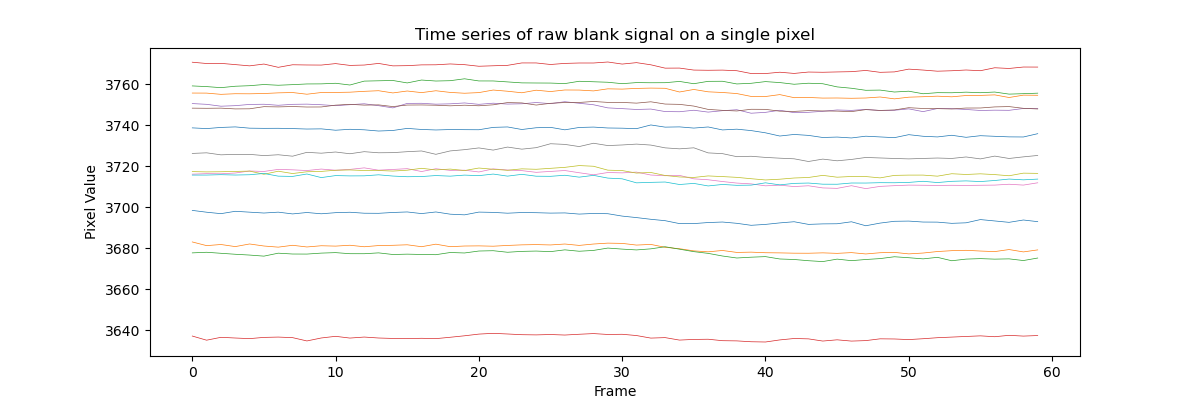

In [191]:
plt.figure(figsize=(12,4))
plt.title('Time series of raw blank signal on a single pixel')

plt.xlabel('Frame')
plt.ylabel('Pixel Value')

for i in range(14):
    plt.plot(time_series[i,:], linewidth=.5)

plt.show()

In [192]:
ft = np.fft.fft(time_series, axis=1)

ps = np.abs(ft)**2

mean_ps = np.mean(ps, axis=0)
ps_mean = np.abs(np.fft.fft(np.mean(time_series, axis=0)))**2

In [193]:
ft.shape

(14, 60)

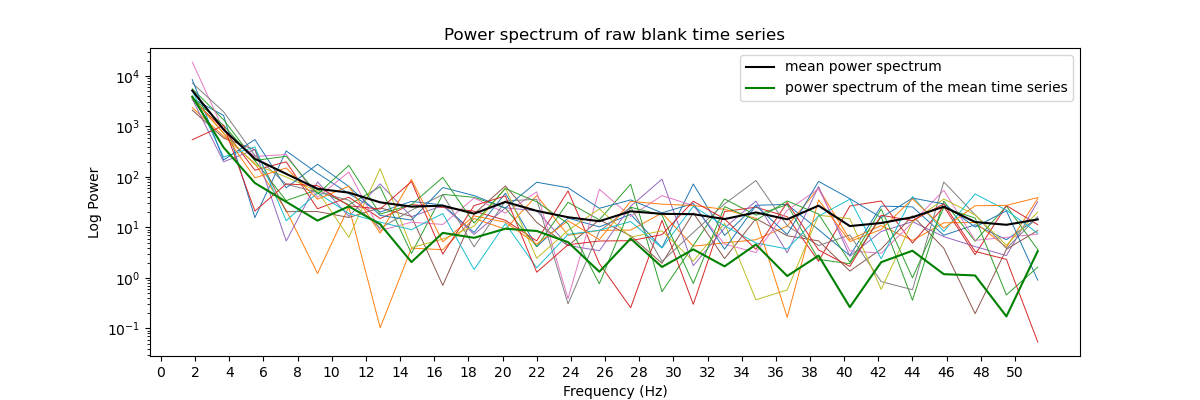

In [194]:
plt.figure(figsize=(12,4))
plt.title('Power spectrum of raw blank time series')

plt.xlabel('Frequency (Hz)')
plt.ylabel('Log Power')
plt.yscale('log')

plt.xticks(range(0,52,2))

for i in range(14):
    plt.plot(f, ps[i,1:Nt//2-1], linewidth=.7)
        
plt.plot(f, mean_ps[1:Nt//2-1],color='black', label='mean power spectrum')
plt.plot(f, ps_mean[1:Nt//2-1],color='green', label='power spectrum of the mean time series')

plt.legend()
plt.show()

## 3 : Linear Model Denoising

In [198]:
fs=110 #Hz
Time = np.array([i*1000/fs for i in range(60)]) #ms

In [199]:
def oscillatory_components(fh, time_range):
    return np.cos(2*np.pi*fh*time_range), np.sin(2*np.pi*fh*time_range)

In [200]:
#heartbeat
cos2_5, sin2_5  = oscillatory_components(2.5, Time)

#camera (5 frequencies)
cos10, sin10  = oscillatory_components(2.5, Time)
cos20, sin20  = oscillatory_components(20, Time)
cos30, sin30  = oscillatory_components(30, Time)
cos40, sin40  = oscillatory_components(40, Time)
cos50, sin50  = oscillatory_components(50, Time)

#unknown
cos3_5, sin3_5  = oscillatory_components(3.5, Time)
cos12, sin12  = oscillatory_components(15, Time)

In [201]:
X1 = np.array([cos2_5, sin2_5, cos10, sin10, cos20, sin20, cos30, sin30, cos40, sin40, cos50, sin50, cos3_5, sin3_5, cos12, sin12])

In [202]:
tau = 950 #ms
bleaching = np.exp(-Time/tau)-1

In [203]:
X2 = np.array([bleaching])

In [204]:
X2.shape

(1, 60)

In [205]:
time_step = 9.09 #ms (environ 1/fs en ms)
Frames = np.array(range(60))

def generate_shape(alpha):
    cum_sum=np.cumsum(alpha)
    r_alpha=np.zeros(60)
    r_alpha[Frames>cum_sum[0]] = .5*(1-np.cos(np.pi*(Frames[Frames>cum_sum[0]]-cum_sum[0])/alpha[1]))
    r_alpha[Frames>cum_sum[1]] = 1
    r_alpha[Frames>cum_sum[2]] = .5*(1+np.cos(np.pi*(Frames[Frames>cum_sum[2]]-cum_sum[2])/alpha[3]))
    r_alpha[Frames>cum_sum[3]] = 0
    return r_alpha

In [206]:
alpha_mat=np.zeros((1250, 4))
r_mat = np.zeros((1250, 60))
i=0
for a1 in range(19, 24):
    for a2 in range(4,9):
        for a3 in range(6,11):
            for a4 in range(6, 16):
                alpha_mat[i]=np.array([a1,a2,a3,a4])
                r_mat[i]=generate_shape(alpha_mat[i])
                i+=1
r_alpha = np.transpose(r_mat)

In [207]:
U, S, Vh=np.linalg.svd(r_alpha,full_matrices=False)

Number of regressors to take

In [208]:
L=10

In [209]:
X3=U[:,:L].T

In [210]:
X3.shape

(10, 60)

In [211]:
X_noise = np.append(X1, X2, axis=0)

In [212]:
X_noise.shape

(17, 60)

In [213]:
X = np.append(X_noise, X3, axis=0).T

In [214]:
X.shape

(60, 27)

In [215]:
Y = Raw_evoked[8, :, x, y]

In [216]:
reg = LinearRegression().fit(X,Y)

In [217]:
reg.score(X,Y)

0.4884788907276397

In [218]:
pred = reg.predict(X)

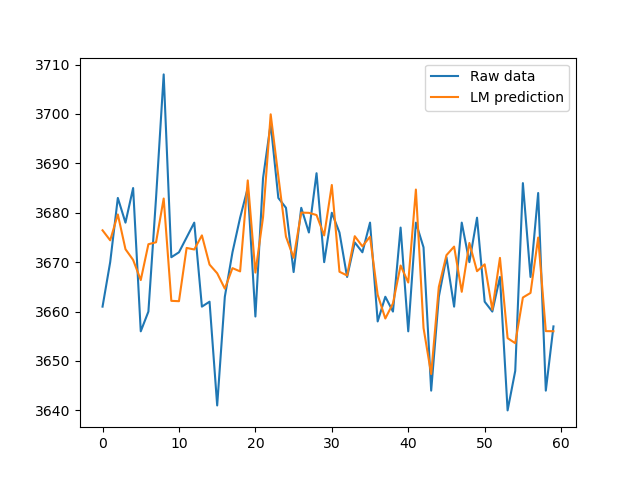

In [219]:
plt.figure()
plt.plot(Y, label='Raw data')
plt.plot(pred, label='LM prediction')
plt.legend()

In [220]:
residuals = Y-pred
µ_res, std_res = np.mean(residuals), np.std(residuals)

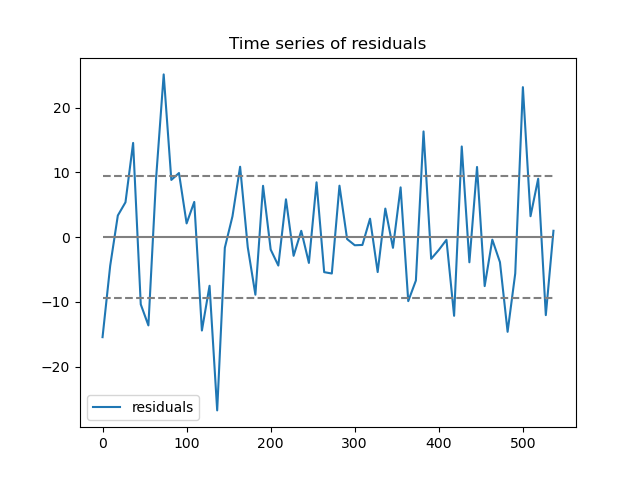

In [221]:
plt.figure()
plt.title('Time series of residuals')
plt.plot(Time, residuals, label='residuals')
plt.hlines(µ_res, Time[0], Time[-1], 'gray')
plt.hlines(µ_res+std_res, Time[0], Time[-1], 'gray', linestyle='dashed')
plt.hlines(µ_res-std_res, Time[0], Time[-1], 'gray', linestyle='dashed')
plt.legend()

In [222]:
ft_res = np.fft.fft(residuals)
ps_res = np.abs(ft_res)**2

In [223]:
f.shape

(28,)

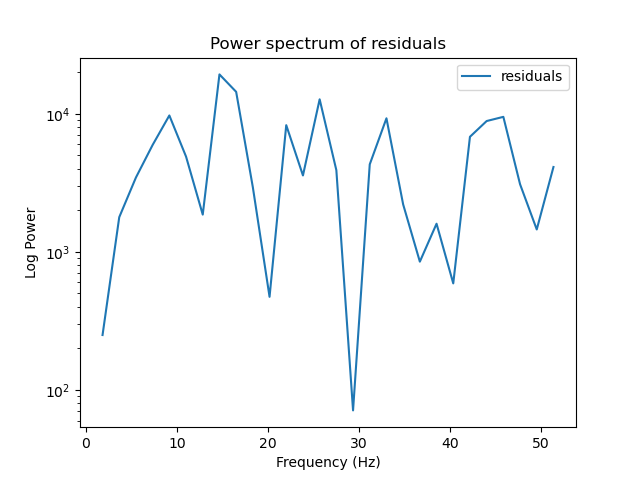

In [224]:
plt.figure()
plt.title('Power spectrum of residuals')
plt.plot(f,ps_res[1:29], label='residuals')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Log Power')
plt.yscale('log')
plt.legend()
plt.show()

In [225]:
reg.coef_

array([ 4.37020931e+14, -9.22082196e+10, -4.36330267e+14, -7.75307246e+10,
       -7.68727018e+11,  9.67532204e+11, -6.90664021e+11,  1.69738944e+11,
        8.13590262e+10, -3.51688331e+11, -4.55705815e-01,  3.37917194e+00,
        7.68727018e+11, -9.67532204e+11, -8.13590262e+10, -3.51688331e+11,
        3.50516315e+01, -3.57151221e+01, -1.77355519e+01, -2.49361390e+01,
       -5.51249202e+00, -2.03436228e+01, -3.42383030e+00, -2.82160833e+01,
       -1.40325944e+00, -1.72517743e+01,  2.53802484e+00])

In [226]:
noise = X_noise.T@reg.coef_[:-10]

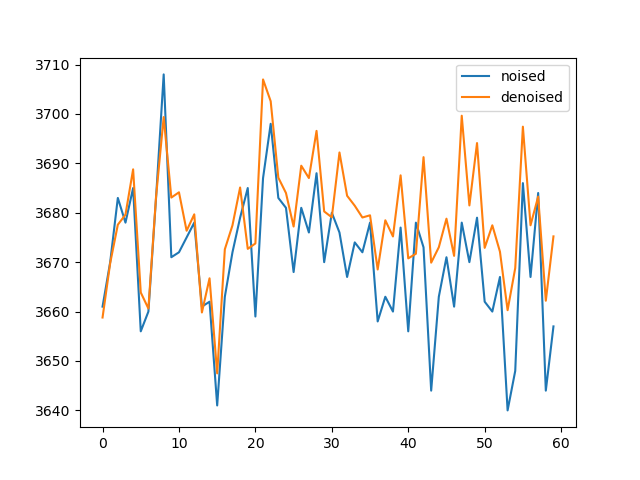

In [227]:
plt.figure()
plt.plot(Y, label='noised')
plt.plot(Y-noise, label='denoised')
plt.legend()

In [228]:
reg.intercept_

3674.2419921875

In [229]:
dF_F = (Y-noise)/reg.intercept_
z_score_dF_F = (dF_F-np.mean(dF_F))/np.std(dF_F)

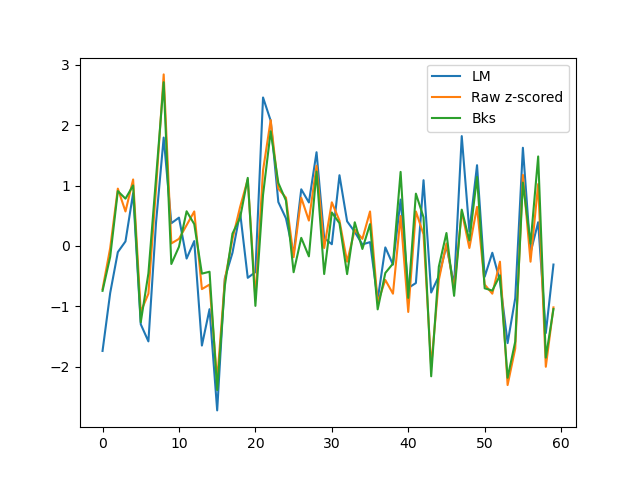

In [230]:
plt.figure()
plt.plot(z_score_dF_F, label='LM')
plt.plot((Raw_evoked[8,:,x,y]-np.mean(Raw_evoked[8,:,x,y]))/np.std(Raw_evoked[8,:,x,y]), label='Raw z-scored')
plt.plot(Bks_evoked[8,:,x,y], label='Bks')
plt.legend()
plt.show()

In [231]:
response = noise = X3.T@reg.coef_[-10:]

In [232]:
response.shape

(60,)

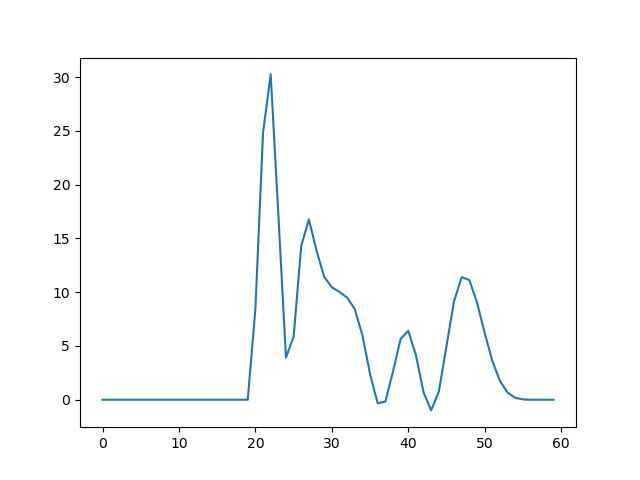

In [233]:
plt.figure()
plt.plot(response)